In [1]:
import warnings

warnings.filterwarnings('ignore')

**Imports**

In [2]:
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
import math
import pyautogui
from playsound import playsound
import os
import sounddevice as sd
import soundfile as sf
import vlc
import time
import os
from tkinter import *
import subprocess
import sys
import tensorflow as tf
import cv2
import numpy as np

**Volume UP**

In [3]:
def increaseVolume():
    devices = AudioUtilities.GetSpeakers()
    interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
    volume = cast(interface, POINTER(IAudioEndpointVolume))

    currentVolumeDb = volume.GetMasterVolumeLevel()
    volume.SetMasterVolumeLevel(currentVolumeDb + 6.0, None)


**Volume DOWN**

In [4]:
def decreaseVolume():
    devices = AudioUtilities.GetSpeakers()
    interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
    volume = cast(interface, POINTER(IAudioEndpointVolume))

    currentVolumeDb = volume.GetMasterVolumeLevel()
    volume.SetMasterVolumeLevel(currentVolumeDb - 6.0, None)


**Take an SS**

In [5]:
def takeSS():
    myScreenshot = pyautogui.screenshot()
    myScreenshot.save(r'saved_ss.png')


**Play a song**

In [6]:
def playMusic():

    os.add_dll_directory(r'C:/Program Files (x86)/VideoLAN')

    p = vlc.MediaPlayer(
        "E:/Downloads/MLSessions-main/MLSessions-main/MLSession_20_09_2021_CNN/Scam-1992-Ringtone.mp3"
    )
    p.play()
    time.sleep(60)
    p.stop()

**HELP**

In [7]:
def showHelpMenu():
    path = 'HELP.pdf'
    os.system(path)


**Record a sound**

In [8]:
def Voice_rec():
    fs = 48000
    myrecording = sd.rec(int(10 * fs), samplerate=fs, channels=2)
    sd.wait()
    return sf.write('Voice_Recording.flac', myrecording, fs)


def recordSound():
    master = Tk()
    Label(master, text=" Voice Recoder : ").grid(row=0, sticky=W, rowspan=5)
    b = Button(master, text="Start", command=Voice_rec)
    b.grid(row=0, column=2, columnspan=2, rowspan=2, padx=5, pady=5)
    mainloop()


**Launch File Explorer**

In [9]:
def launchFileExplorer():
    path = r'C:/Program Files (x86)/IronPython 2.7/Lib'
    sys.path.append(path)
    subprocess.Popen('explorer "C:/"')


**Function Call**

In [12]:
import cv2
import imutils 
import numpy as np
from sklearn.metrics import pairwise

bg = None


# Function - To find the running average over the background
def run_avg(image, accumWeight):
    global bg
    if bg is None:
        bg = image.copy().astype("float")
        return
    cv2.accumulateWeighted(image, bg, accumWeight)


# Function - To segment the region of hand in the image
def segment(image, threshold=30):
    global bg
    diff = cv2.absdiff(bg.astype("uint8"), image)

    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[0]

    if len(cnts) == 0:
        return
    else:
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)


# Function - To count the number of fingers in the segmented hand region

# Main function
if __name__ == "__main__":
    accumWeight = 0.5

    camera = cv2.VideoCapture(0, cv2.CAP_DSHOW)

    top, right, bottom, left = 10, 350, 210, 550

    num_frames = 0

    imageNumber = 0
    calibrated = False

    while (True):
        (grabbed, frame) = camera.read()

        frame = imutils.resize(frame, width=700)

        frame = cv2.flip(frame, 1)

        clone = frame.copy()

        (height, width) = frame.shape[:2]

        roi = frame[top:bottom, right:left]

        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)

        if num_frames < 30:
            run_avg(gray, accumWeight)
            if num_frames == 1:
                print(">>> Please wait! calibrating...")
            elif num_frames == 29:
                print(">>> Calibration successfull...")
        else:
            hand = segment(gray)

            if hand is not None:
                (thresholded, segmented) = hand
                # show the thresholded image
                cv2.imshow("Thesholded", thresholded)
                keypress = cv2.waitKey(1) & 0xFF
                if keypress%256 == 32:
                    # Set the directory CORRECTLY
                    directory = "opencv_frame.jpg"
                    cv2.imwrite(directory, thresholded)
                    print(directory)
                    break

        # draw the segmented hand
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

        num_frames += 1

        cv2.imshow("Video Feed", clone)

# free up memory
camera.release()
cv2.destroyAllWindows()

>>> Please wait! calibrating...
>>> Calibration successfull...
opencv_frame.jpg


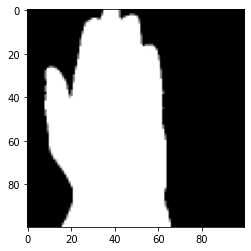

Predicted Class:  6
Gesture Predicted:  Palm


In [13]:
export_dir = "Model_Hand_Gestures"
new_model = tf.keras.models.load_model(export_dir)

import matplotlib.pyplot as plt

class_map = {
    1: 'C',
    2: 'Fist',
    3: 'Index',
    4: 'L',
    5: 'OK',
    6: 'Palm',
    7: 'Thumb'
}


def predictClass(img_path: str) -> int:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100, 100))
    plt.imshow(img, cmap='gray')
    plt.show()
    img = img[np.newaxis, :, :, np.newaxis]
    predicted_class = list(new_model.predict(img)[0])
    # print(predicted_class)
    return predicted_class.index(max(predicted_class)) + 1


def automateTask(class_no):
    if class_no == 6:
        launchFileExplorer()
    elif class_no == 4:
        showHelpMenu()
    elif class_no == 2:
        takeSS()
    elif class_no == 7:
        recordSound()
    elif class_no == 3:
        increaseVolume()
    elif class_no == 5:
        playMusic()
    else:
        decreaseVolume()


class_predicted = predictClass("opencv_frame.jpg")
print("Predicted Class: ", class_predicted)
print("Gesture Predicted: ", class_map[class_predicted])
automateTask(class_predicted)